In [109]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line, circle_perimeter, line_aa, ellipse_perimeter
from skimage.feature import canny
import copy
from math import atan2
from skimage.transform import resize
from image_transformations import *
from time import time

In [110]:
def plot_grayscale_pic(picture, fig_width=7, fig_length=7):
    plt.figure(figsize=(fig_width,fig_length))
    plt.imshow(picture, cmap=plt.get_cmap("gray"), vmin=0.0, vmax=1.0)
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

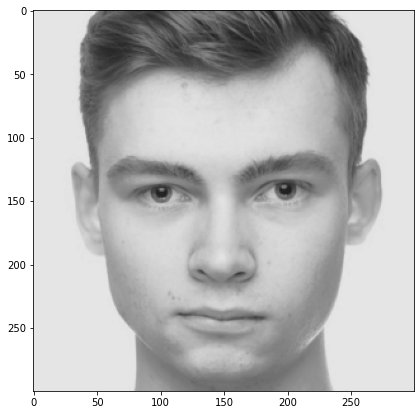

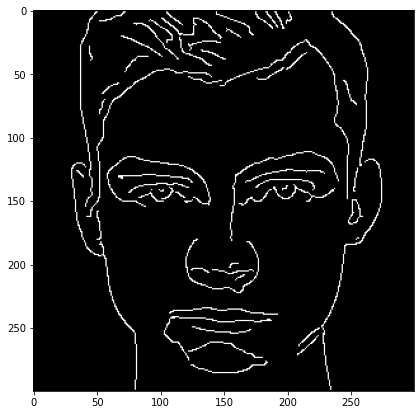

In [111]:
LONG_SIDE = 300

img = mpimg.imread("dokpilt3.jpg")
img = largest_square(img)
img = resize(img, (LONG_SIDE, LONG_SIDE))

orig_pic = rgb2gray(img)

edges = canny(orig_pic, sigma=2)
# orig_pic[edges] = 0.3
orig_pic = orig_pic*0.9

plot_grayscale_pic(orig_pic)
plot_grayscale_pic(edges)

In [112]:
orig_pic[0][:5]

array([0.89638094, 0.89638094, 0.89638094, 0.89638094, 0.89638094])

In [113]:
def create_rectangle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    nails_top = [(0, i) for i in range(0, width, nail_step)]
    nails_bot = [(height-1, i) for i in range(0, width, nail_step)]
    nails_right = [(i, width-1) for i in range(1, height-1, nail_step)]
    nails_left = [(i, 0) for i in range(1, height-1, nail_step)]
    nails = nails_top + nails_right + nails_bot + nails_left
    
    return nails

def create_circle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    centre = (height // 2, width // 2)
    radius = min(height, width) // 2 - 1
    rr, cc = circle_perimeter(centre[0], centre[1], radius)
    nails = list(set([(rr[i], cc[i]) for i in range(len(cc))]))
    nails.sort(key=lambda c: atan2(c[0] - centre[0], c[1] - centre[1]))
    nails = nails[::nail_step]
    
    return nails

def init_black_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.zeros((height, width))

def init_white_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.ones((height, width))

In [114]:
def get_aa_line(from_pos, to_pos, str_strength, picture):
    rr, cc, val = line_aa(from_pos[0], from_pos[1], to_pos[0], to_pos[1])
    line = picture[rr, cc] + str_strength * val
    line = np.clip(line, a_min=0, a_max=1)
    
    return line, rr, cc

def find_best_nail_position(current_position, nails, str_pic, orig_pic, str_strength):

    best_cumulative_improvement = -99999
    best_nail_position = None
    best_nail_idx = None

    for nail_idx, nail_position in enumerate(nails):

        overlayed_line, rr, cc = get_aa_line(current_position, nail_position, str_strength, str_pic)

        before_overlayed_line_diff = np.abs(str_pic[rr, cc] - orig_pic[rr, cc])**2
        after_overlayed_line_diff = np.abs(overlayed_line - orig_pic[rr, cc])**2

        cumulative_improvement =  np.sum(before_overlayed_line_diff - after_overlayed_line_diff)

        if cumulative_improvement >= best_cumulative_improvement:
            best_cumulative_improvement = cumulative_improvement
            best_nail_position = nail_position
            best_nail_idx = nail_idx

    return best_nail_idx, best_nail_position, best_cumulative_improvement

In [115]:
def create_art(nails, orig_pic, str_pic, str_strength):
    
    start = time()
    iter_times = []
    
    current_position = nails[0]
    pull_order = [0]

    i = 0
    while True:
        start_iter = time()
        
        i += 1
        if i > 2500:
            break
        if i % 200 == 0:
            plot_grayscale_pic(str_pic)
        
        idx, best_nail_position, best_cumulative_improvement = find_best_nail_position(current_position, nails,
                                                                                  str_pic, orig_pic, str_strength)
        pull_order.append(idx)
        best_overlayed_line, rr, cc = get_aa_line(current_position, best_nail_position, str_strength, str_pic)
        str_pic[rr, cc] = best_overlayed_line
        
        current_position = best_nail_position
        iter_times.append(time() - start_iter)

    print(f"Time: {time() - start}")
    print(f"Avg iteration time: {np.mean(iter_times)}")
    return pull_order

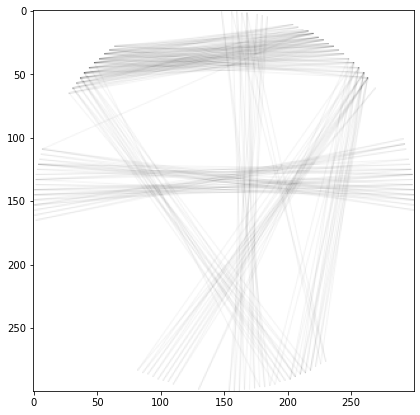

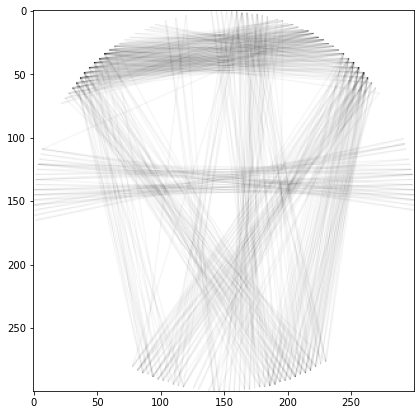

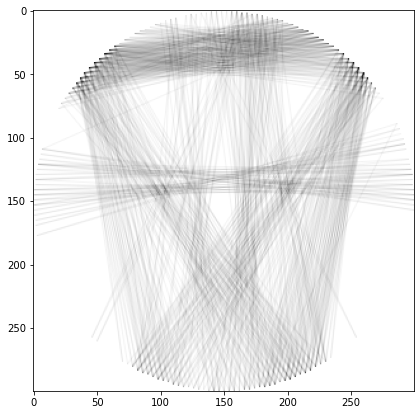

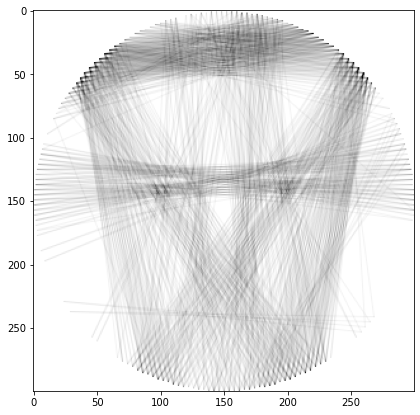

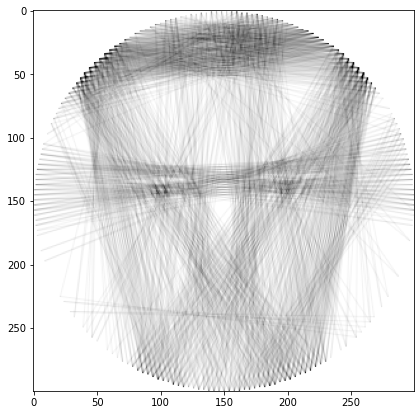

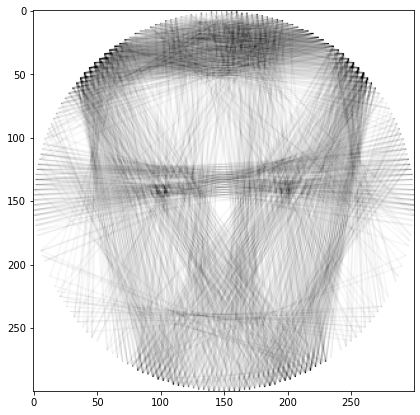

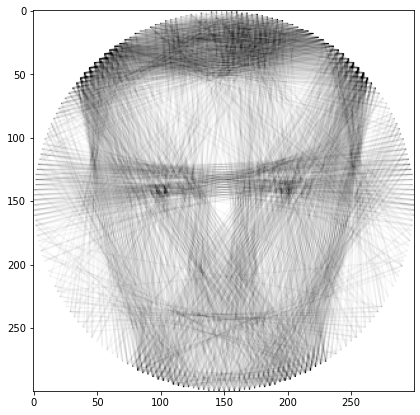

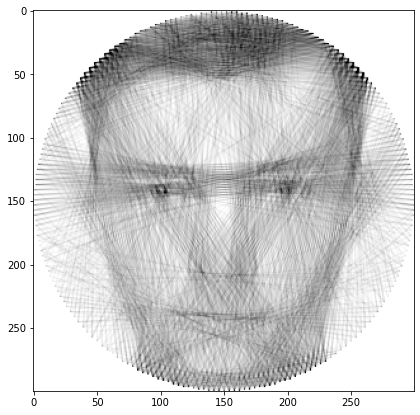

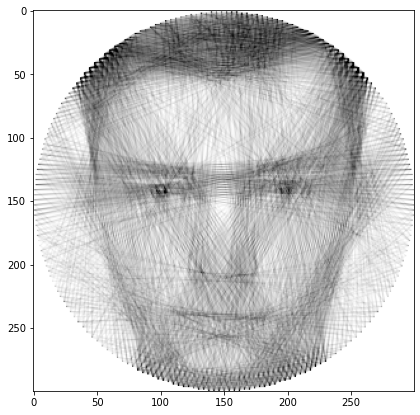

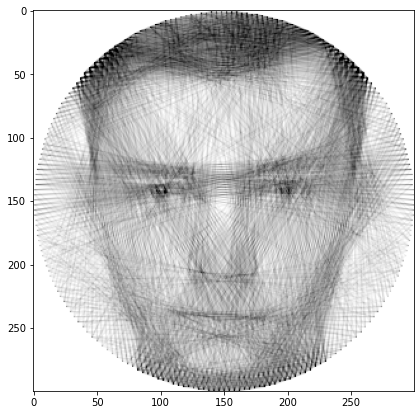

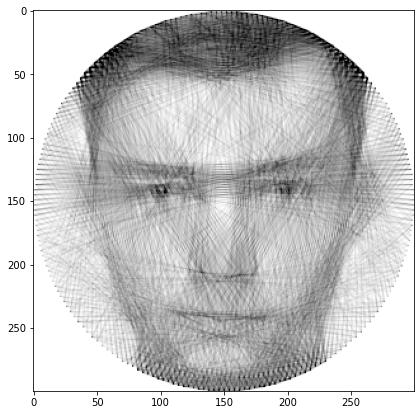

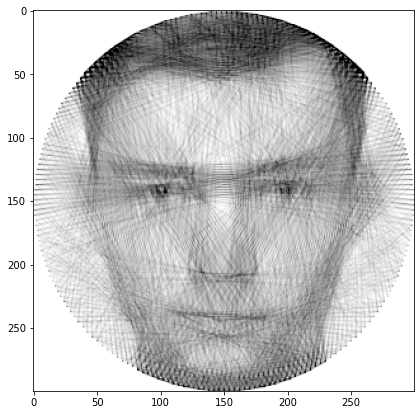

Time: 53.53523564338684
Avg iteration time: 0.021413600540161132


In [116]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_white_canvas(orig_pic)
pull_order = create_art(nails, orig_pic, str_pic, -0.05)

In [117]:
print(f"Thread pull order by nail index:\n{'-'.join([str(idx) for idx in pull_order])}")

Thread pull order by nail index:
0-100-1-101-2-102-0-97-4-98-5-99-210-95-209-94-208-93-207-94-210-100-6-103-7-104-3-103-1-102-7-105-9-107-10-106-8-104-2-100-7-99-4-105-10-69-23-71-24-73-26-70-25-75-27-72-24-74-29-80-28-71-25-76-27-70-22-72-23-74-25-69-29-78-26-69-28-79-30-74-26-77-25-78-30-68-29-73-27-71-26-76-24-146-23-70-28-67-29-81-171-80-169-81-172-79-141-80-140-81-170-80-27-69-31-76-23-144-25-72-21-70-30-81-173-80-145-24-75-28-72-31-67-22-142-78-24-148-79-168-81-27-66-29-71-22-145-78-175-83-174-79-142-24-70-31-77-163-78-149-52-150-55-152-57-155-59-157-61-154-54-138-57-151-27-77-143-81-141-25-79-144-26-75-22-147-25-73-30-66-28-74-21-143-80-139-56-156-60-153-55-168-80-148-77-175-79-140-26-67-24-143-60-158-59-139-81-142-27-64-19-71-32-68-28-150-77-146-79-171-82-29-79-149-25-168-53-149-22-73-34-72-26-80-144-31-65-29-75-23-147-56-145-25-172-77-164-76-150-22-76-175-82-141-58-138-20-70-29-142-80-174-24-69-33-78-176-79-145-23-148-78-146-21-76-35-71-30-80-166-82-140-25-170-56-167-26-81-144

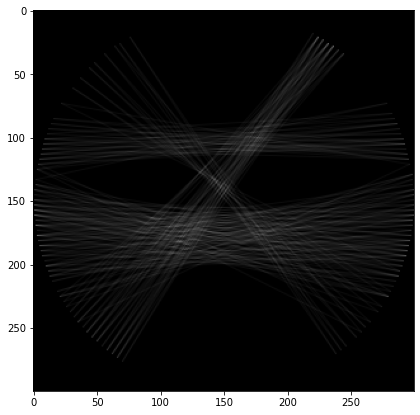

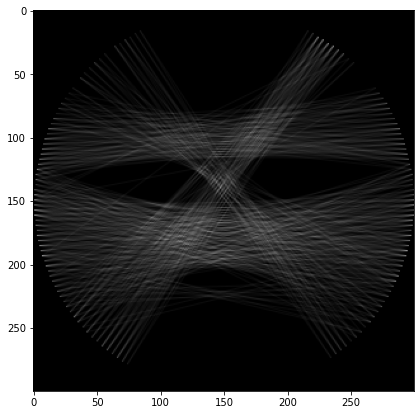

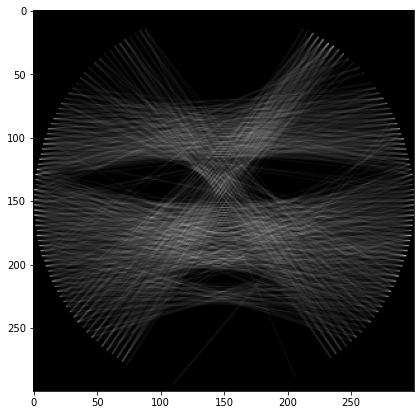

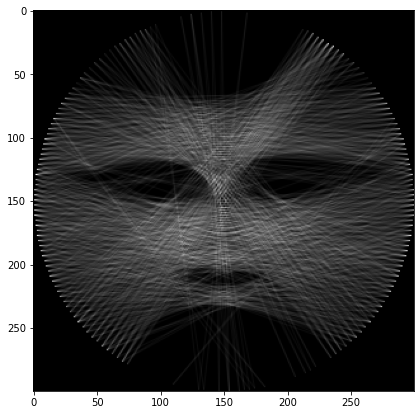

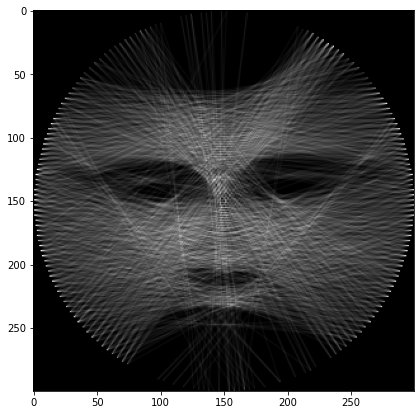

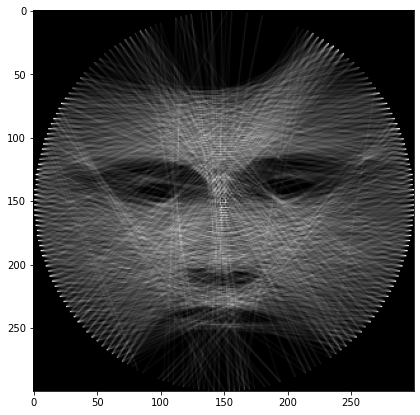

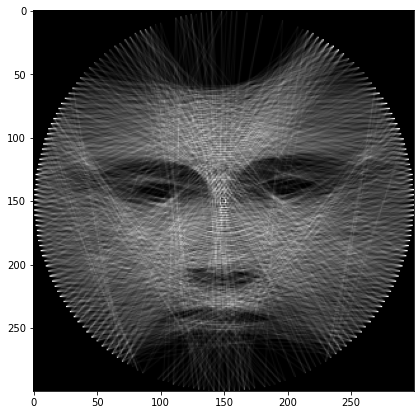

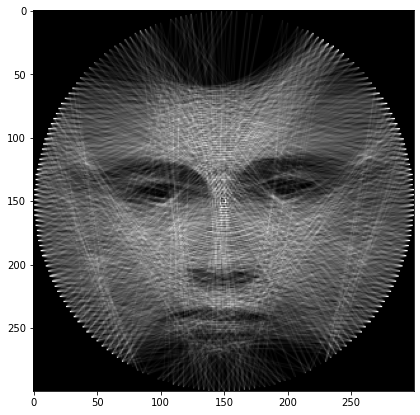

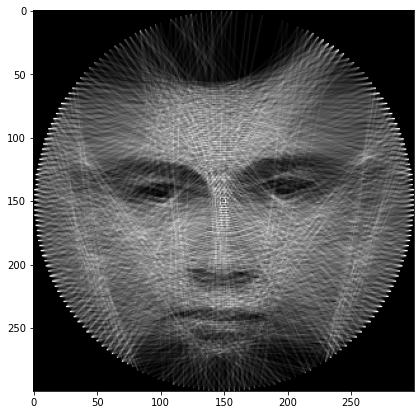

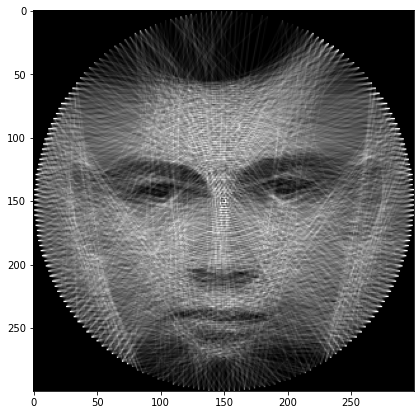

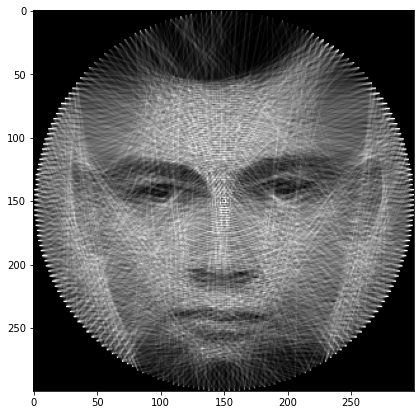

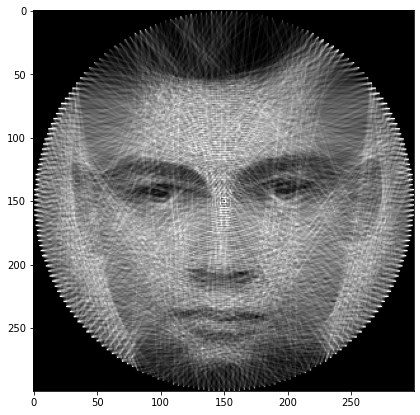

Time: 54.00992679595947
Avg iteration time: 0.021603506088256837


[0,
 116,
 208,
 113,
 206,
 109,
 204,
 110,
 203,
 108,
 207,
 117,
 210,
 112,
 202,
 115,
 209,
 118,
 206,
 108,
 200,
 114,
 210,
 110,
 201,
 116,
 2,
 120,
 205,
 109,
 198,
 105,
 203,
 111,
 196,
 103,
 200,
 117,
 208,
 107,
 204,
 114,
 198,
 107,
 207,
 120,
 209,
 112,
 0,
 109,
 202,
 118,
 3,
 126,
 24,
 127,
 2,
 115,
 197,
 100,
 193,
 103,
 202,
 113,
 196,
 101,
 190,
 73,
 182,
 72,
 180,
 71,
 183,
 74,
 185,
 73,
 180,
 74,
 184,
 72,
 179,
 71,
 181,
 74,
 187,
 76,
 185,
 71,
 188,
 73,
 186,
 75,
 183,
 76,
 192,
 104,
 204,
 121,
 206,
 115,
 208,
 123,
 22,
 124,
 4,
 86,
 6,
 91,
 8,
 93,
 10,
 94,
 9,
 95,
 12,
 92,
 11,
 93,
 7,
 90,
 9,
 89,
 12,
 97,
 15,
 96,
 11,
 90,
 8,
 94,
 16,
 96,
 13,
 88,
 10,
 97,
 14,
 94,
 7,
 129,
 26,
 130,
 27,
 132,
 29,
 134,
 32,
 136,
 34,
 135,
 31,
 131,
 6,
 124,
 210,
 113,
 199,
 104,
 195,
 106,
 192,
 108,
 0,
 120,
 201,
 102,
 204,
 122,
 209,
 114,
 3,
 119,
 1,
 111,
 197,
 116,
 198,
 100,
 191,
 74,
 179

In [118]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_black_canvas(orig_pic)
create_art(nails, orig_pic, str_pic, 0.05)

In [124]:
def scale_nails(x_ratio, y_ratio, nails):
    return [(int(y_ratio*nail[0]), int(x_ratio*nail[1])) for nail in nails]

def circular_pull_order_to_array_bw(order, canvas, nails):
    # Draw a black and white pull order on the defined resolution

    for pull_start, pull_end in zip(order, order[1:]):  # pairwise iteration
        rr, cc, val = line_aa(nails[pull_start][0], nails[pull_start][1],
                              nails[pull_end][0], nails[pull_end][1])
        canvas[rr, cc] += val * -0.1

    return np.clip(canvas, a_min=0, a_max=1)


image_dimens = 900, 900
blank = np.ones((image_dimens[0], image_dimens[1]))
scaled_nails = scale_nails(
    image_dimens[1] / len(orig_pic),
    image_dimens[0] / len(orig_pic[0]),
    nails
)

result = circular_pull_order_to_array_bw(
    pull_order,
    blank,
    scaled_nails
)
mpimg.imsave('output.png', result, cmap=plt.get_cmap("gray"))